### Project 2
### DSC 680
### Alexis Zimmer
### April 30, 2023

In [78]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## library versions
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('seaborn version:', sns.__version__)

pandas version: 1.0.3
numpy version: 1.18.1
seaborn version: 0.11.2


In [53]:
## ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## print option
pd.set_option('display.max_columns', None)


## Datasets

In [54]:
## load datasets
df_train = pd.read_csv("train_set.csv")

df_test = pd.read_csv("test_set.csv")

df_val = pd.read_csv("validation_set.csv")

In [55]:
df_train.head()

,id,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type
0,1,John Doe,"Category 1: 'Risk' (Low performance, Low poten...",John has not progressed in his position. He is...,False,True,0,287,5,0,0,john ha not progressed in his position he is c...,train
1,10045,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has been having trouble in all a...,False,False,0,430,6,0,0,douglas henry ha been having trouble in all ar...,train
2,10044,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas has a lot to work on and areas to grow...,False,False,0,290,4,0,0,douglas ha a lot to work on and area to grow i...,train
3,10005,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...","Freddie is a nice guy, but his performance and...",False,True,0,418,5,0,0,freddie is a nice guy but his performance and ...,train
4,10004,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie has been quite disappointing this quar...,False,False,0,449,4,0,0,freddie ha been quite disappointing this quart...,train


In [56]:
df_test.head()

,id,person_name,nine_box_category,feedback,updated,reviewed,label,performance_class,potential_class,feedback_clean
0,20051,Lacey Howard,"Category 1: 'Risk' (Low performance, Low poten...",Lacey's performance has been sub standard in t...,True,True,0,0,0,laceys performance ha been sub standard in the...
1,20214,Jon Fischer,"Category 1: 'Risk' (Low performance, Low poten...",Jon Fischer has not been instrumental so far a...,False,True,0,0,0,jon fischer ha not been instrumental so far at...
2,20213,Jon Fischer,"Category 1: 'Risk' (Low performance, Low poten...",Jon fisher is a disappointment. Lazy and compl...,False,True,0,0,0,jon fisher is a disappointment lazy and compla...
3,20212,Jon Fischer,"Category 1: 'Risk' (Low performance, Low poten...",Jon has been really difficult to work with for...,False,True,0,0,0,jon ha been really difficult to work with for ...
4,20186,Johanna Duke,"Category 1: 'Risk' (Low performance, Low poten...",Despite Johanna Duke appearing to be a capable...,True,True,0,0,0,despite johanna duke appearing to be a capable...


In [57]:
df_val.head()

,id,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type
0,10046,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has not performed at a high leve...,False,False,0,321,4,0,0,douglas henry ha not performed at a high level...,val
1,10002,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies onboarded the team a few months...,False,False,0,502,4,0,0,freddie davy onboarded the team a few month ag...,val
2,10001,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies needs lots of improvement in hi...,False,False,0,265,2,0,0,freddie davy need lot of improvement in his wo...,val
3,86,Broderick Hays,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is not doing so well. His work on a ...,False,False,0,226,4,0,0,broderick is not doing so well his work on a d...,val
4,84,Broderick Hays,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is always such a wildcard to put in ...,False,False,0,514,4,0,0,broderick is always such a wildcard to put in ...,val


In [59]:
## scrub dfs
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_val.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [60]:
df_test = df_test.dropna()
df_val = df_val.dropna()
df_train = df_train.dropna()

In [61]:
## set indexes
df_test.set_index('id', inplace = True)
df_val.set_index('id', inplace = True)
df_train.set_index('id', inplace = True)

### Sentiment Analysis Prep

In [81]:
## Download the lexicon
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [82]:
## import library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer()

In [83]:
employee_list = df_train['person_name'].unique()
employee_list

array(['Douglas Henry', 'Freddie Davies', 'Broderick Hays',
       'Mackenzie Jennings', 'Cason Vargas', 'Andy Kennedy',
       'Jaiden Horne', 'Katherine Terry', 'Tom Barrett', 'Andrea Thomas',
       'Jalen Summers', 'Kohen Norris', 'Wade Stanley', 'Addison Cohen',
       'Sonny Kidd', 'Amaya Gay', 'Brynlee Byers', 'Elliot Gray',
       'Emerson Rose', 'Jayden Rees', 'Amelie Martin', 'Alecia Keys',
       'Esmeralda Langley', 'Isabella James', 'Lance Hatfield',
       'Peter Allen', 'Aniya Sullivan', 'Markus Mathews', 'Jessica Dixon',
       'Benjamin Roberts', 'Eloise Foster', 'Leo Lee', 'Braydon Terrell',
       'Azariah Mcmillan', 'Morgan Butler', 'Kyle Lawson',
       'Sophie Murray', 'Kallie Beard', 'Peter Lloyd', 'Tom Houghton',
       'Jay Reid', 'Alfie Wright', 'Ollie Mason', 'David Kelly',
       'Braiden Santos', 'Heidi Wallace', 'Daniel Carr', 'Bobby Lowe',
       'Rebecca Murphy', 'Declan Houghton', 'Joseph Burke',
       'Tom Williams', 'Edward Bates', 'Natasha Richardso

In [84]:
df_train['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df_train['feedback_clean']]
df_train['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df_train['feedback_clean']]
df_train['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df_train['feedback_clean']]
df_train['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df_train['feedback_clean']]

In [85]:
df_train.head()

,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type,compound,neg,neu,pos,polarity,vader_prediction
id,,,,,,,,,,,,,,,,,,
10046,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has not performed at a high leve...,False,False,0,321,4,0,0,douglas henry ha not performed at a high level...,val,-0.3182,0.121,0.807,0.072,negative,negative
10002,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies onboarded the team a few months...,False,False,0,502,4,0,0,freddie davy onboarded the team a few month ag...,val,0.8957,0.075,0.725,0.200,negative,positive
10001,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies needs lots of improvement in hi...,False,False,0,265,2,0,0,freddie davy need lot of improvement in his wo...,val,0.7906,0.025,0.827,0.148,negative,positive
86,Broderick Hays,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is not doing so well. His work on a ...,False,False,0,226,4,0,0,broderick is not doing so well his work on a d...,val,0.5777,0.101,0.704,0.196,negative,positive
84,Broderick Hays,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is always such a wildcard to put in ...,False,False,0,514,4,0,0,broderick is always such a wildcard to put in ...,val,-0.5086,0.084,0.864,0.052,negative,negative


In [86]:
## add column to simplify polarity score

def categorise(row):  
    if row['label'] >= 0 and row['label'] <= 2:
        return 'negative'
    elif row['label'] > 2 and row['label'] <= 5:
        return 'neutral'
    elif row['label'] > 5  and row['label'] <= 8:
        return 'positive'
    return 'error'

df_train['polarity'] = df_train.apply(lambda row: categorise(row), axis=1)
df_train.head()

,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type,compound,neg,neu,pos,polarity,vader_prediction
id,,,,,,,,,,,,,,,,,,
10046,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has not performed at a high leve...,False,False,0,321,4,0,0,douglas henry ha not performed at a high level...,val,-0.3182,0.121,0.807,0.072,negative,negative
10002,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies onboarded the team a few months...,False,False,0,502,4,0,0,freddie davy onboarded the team a few month ag...,val,0.8957,0.075,0.725,0.200,negative,positive
10001,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies needs lots of improvement in hi...,False,False,0,265,2,0,0,freddie davy need lot of improvement in his wo...,val,0.7906,0.025,0.827,0.148,negative,positive
86,Broderick Hays,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is not doing so well. His work on a ...,False,False,0,226,4,0,0,broderick is not doing so well his work on a d...,val,0.5777,0.101,0.704,0.196,negative,positive
84,Broderick Hays,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is always such a wildcard to put in ...,False,False,0,514,4,0,0,broderick is always such a wildcard to put in ...,val,-0.5086,0.084,0.864,0.052,negative,negative


## VADER

In [87]:
## check VADER performance

def VADER_output(output_dict):
  
  polarity = "neutral"

  if(output_dict['compound']>= 0.05):
    polarity = "positive"

  elif(output_dict['compound']<= -0.05):
    polarity = "negative"

  return polarity

def predict_sentiment(text):
  
  output_dict =  analyzer.polarity_scores(text)
  return VADER_output(output_dict)

## Run the predictions
df_train["vader_prediction"] = df_train["feedback"].apply(predict_sentiment)

## comparison check
df_train.sample(5)

,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type,compound,neg,neu,pos,polarity,vader_prediction
id,,,,,,,,,,,,,,,,,,
10223,Andy Kennedy,"Category 1: 'Risk' (Low performance, Low poten...","Andy was a very inconsistent player, he would ...",True,True,0,217,3,0,0,andy wa a very inconsistent player he would be...,val,-0.5634,0.136,0.807,0.057,negative,negative
10160,Nicole Barnes,Category 8: 'High Potential' (Moderate perform...,Nicole has shown so much growth this past quar...,False,False,7,301,4,1,2,nicole ha shown so much growth this past quart...,val,0.9322,0.000,0.761,0.239,positive,positive
241,Eloise Foster,Category 6: 'High Performer' (High performance...,In regards to EloiseÃ¢â‚¬â„¢s quarterly work c...,True,True,5,488,5,2,1,in regard to eloiseãââs quarterly work conduct...,val,0.9633,0.000,0.789,0.211,neutral,positive
20008,Elliot Gray,Category 2: 'Average performer' (Moderate perf...,Elliot is fairly effective at managing his wor...,True,True,1,203,4,1,0,elliot is fairly effective at managing his wor...,val,0.8197,0.052,0.697,0.251,negative,positive
217,Finley Gray,Category 6: 'High Performer' (High performance...,Finley Gray has been an asset to our company a...,True,True,5,319,4,2,1,finley gray ha been an asset to our company a ...,val,0.9260,0.000,0.791,0.209,neutral,positive


In [89]:
## accuracy score

accuracy = accuracy_score(df_train['polarity'], df_train['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

## classification report
print(classification_report(df_train['polarity'], df_train['vader_prediction']))

Accuracy: 0.3706896551724138

              precision    recall  f1-score   support

    negative       0.83      0.24      0.37        42
     neutral       0.33      0.02      0.04        42
    positive       0.32      1.00      0.48        32

    accuracy                           0.37       116
   macro avg       0.49      0.42      0.30       116
weighted avg       0.51      0.37      0.28       116



## Test and Adjust
VADER best performed with negative performance reviews, while struggling with the neutral vs positive reviews. After closer review of the 'nine_box_category', numbers do not positively correlate with a more positive review. Adjustments are below.

In [93]:
df_train2 = pd.read_csv("train_set.csv")
df_train2.head()

,id,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type
0,1,John Doe,"Category 1: 'Risk' (Low performance, Low poten...",John has not progressed in his position. He is...,False,True,0,287,5,0,0,john ha not progressed in his position he is c...,train
1,10045,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has been having trouble in all a...,False,False,0,430,6,0,0,douglas henry ha been having trouble in all ar...,train
2,10044,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas has a lot to work on and areas to grow...,False,False,0,290,4,0,0,douglas ha a lot to work on and area to grow i...,train
3,10005,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...","Freddie is a nice guy, but his performance and...",False,True,0,418,5,0,0,freddie is a nice guy but his performance and ...,train
4,10004,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie has been quite disappointing this quar...,False,False,0,449,4,0,0,freddie ha been quite disappointing this quart...,train


In [94]:
## scrub df_train2
df_train2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train2 = df_train2.dropna()
df_train2.set_index('id', inplace = True)

In [95]:
df_train2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df_train2['feedback_clean']]
df_train2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df_train2['feedback_clean']]
df_train2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df_train2['feedback_clean']]
df_train2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df_train2['feedback_clean']]

In [99]:
## add column to simplify polarity score

def categorise(row):  
    if row['label'] == 0:
        return 'negative'
    elif row['label'] == 1:
        return 'negative'
    elif row['label'] == 3:
        return 'negative'
    elif row['label'] == 2:
        return 'neutral'
    elif row['label'] == 4:
        return 'neutral'
    elif row['label'] == 6:
        return 'neutral'
    elif row['label'] == 5:
        return 'positive'
    elif row['label'] == 7:
        return 'positive' 
    elif row['label'] == 8:
        return 'positive'  
    return 'error'

df_train2['polarity'] = df_train2.apply(lambda row: categorise(row), axis=1)
df_train2.head()

,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type,compound,neg,neu,pos,polarity
id,,,,,,,,,,,,,,,,,
1,John Doe,"Category 1: 'Risk' (Low performance, Low poten...",John has not progressed in his position. He is...,False,True,0,287,5,0,0,john ha not progressed in his position he is c...,train,0.5859,0.000,0.906,0.094,negative
10045,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has been having trouble in all a...,False,False,0,430,6,0,0,douglas henry ha been having trouble in all ar...,train,-0.5736,0.152,0.745,0.102,negative
10044,Douglas Henry,"Category 1: 'Risk' (Low performance, Low poten...",Douglas has a lot to work on and areas to grow...,False,False,0,290,4,0,0,douglas ha a lot to work on and area to grow i...,train,-0.3891,0.132,0.791,0.078,negative
10005,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...","Freddie is a nice guy, but his performance and...",False,True,0,418,5,0,0,freddie is a nice guy but his performance and ...,train,-0.5659,0.119,0.800,0.081,negative
10004,Freddie Davies,"Category 1: 'Risk' (Low performance, Low poten...",Freddie has been quite disappointing this quar...,False,False,0,449,4,0,0,freddie ha been quite disappointing this quart...,train,-0.8748,0.180,0.742,0.079,negative


In [100]:
## check VADER performance (2)
## Run the predictions
df_train2["vader_prediction"] = df_train2["feedback"].apply(predict_sentiment)

## comparison check
df_train2.sample(5)

,person_name,nine_box_category,feedback,adjusted,reviewed,label,feedback_len,num_of_sent,performance_class,potential_class,feedback_clean,data_type,compound,neg,neu,pos,polarity,vader_prediction
id,,,,,,,,,,,,,,,,,,
466,Dallas Whitehead,Category 6: 'High Performer' (High performance...,Dallas is a very proficient worker. He has the...,False,False,5,317,4,2,1,dallas is a very proficient worker he ha the k...,train,0.9169,0.023,0.759,0.219,positive,positive
632,Jamari Roberts,Category 8: 'High Potential' (Moderate perform...,"Jamari is a wonderful people's person, a great...",False,False,7,388,5,1,2,jamari is a wonderful people person a great sa...,train,0.9764,0.047,0.604,0.349,positive,positive
171,Amaya Gay,Category 2: 'Average performer' (Moderate perf...,Amaya always tries her best on her assignments...,False,False,1,492,4,1,0,amaya always try her best on her assignment an...,train,0.9664,0.020,0.751,0.229,negative,positive
686,Graysen Sellers,"Category 9: 'Star' (High performance, High pot...",Graysen excels at completing tasks. He consist...,False,False,8,300,5,2,2,graysen excels at completing task he consisten...,train,0.9423,0.000,0.735,0.265,positive,positive
47,Wade Stanley,"Category 1: 'Risk' (Low performance, Low poten...","Unfortunately, Mr. Stanley has shown time and ...",False,False,0,449,5,0,0,unfortunately mr stanley ha shown time and tim...,train,0.8296,0.042,0.776,0.182,negative,positive


In [101]:
## accuracy score

accuracy = accuracy_score(df_train2['polarity'], df_train2['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

## classification report
print(classification_report(df_train2['polarity'], df_train2['vader_prediction']))

Accuracy: 0.4481707317073171

              precision    recall  f1-score   support

    negative       0.85      0.31      0.45       249
     neutral       0.21      0.02      0.03       189
    positive       0.39      0.99      0.56       218

    accuracy                           0.45       656
   macro avg       0.49      0.44      0.35       656
weighted avg       0.52      0.45      0.36       656



## Results Comparison

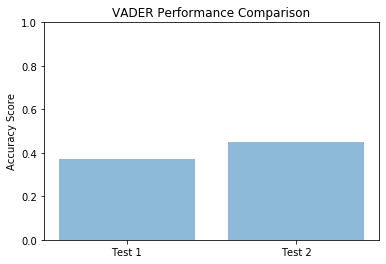

In [109]:
objects = ('Test 1', 'Test 2')
y_pos = np.arange(len(objects))
performance = [.37,.45]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim((0,1))
plt.ylabel('Accuracy Score')
plt.title('VADER Performance Comparison')

plt.show()

In [114]:
# initialize list of lists
data = [['test 1', '.37', '.51', '.37', '.28'], ['test 2', '.45', '.52', '.45', '.36']]
  
# Create the pandas DataFrame
df2 = pd.DataFrame(data, columns=['Test', 'Accuracy Score', 'Average Precision', 'Average Recall', 'Average F1-Score'])
  
# print dataframe.
df2

,Test,Accuracy Score,Average Precision,Average Recall,Average F1-Score
0,test 1,.37,.51,.37,.28
1,test 2,.45,.52,.45,.36
